# Uber Churn Prediction Project

Import necessary libraries and set plot style

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Read in data

In [2]:
df = pd.read_csv('raw_data.csv')

Explore general information of the dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [5]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

Fill na in the two rating features with median of the column

In [6]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='median', axis=0)
imputed_data = imr.fit_transform(df[['avg_rating_by_driver', 'avg_rating_of_driver']])
imputed_data = pd.DataFrame(imputed_data)
imputed_data.columns = ['avg_rating_by_driver', 'avg_rating_of_driver']
df.drop(imputed_data.columns, axis=1, inplace=True)
df = df.join(imputed_data)

Create a new class for missing data in phone

In [7]:
df.phone.fillna('No Phone', inplace=True)

Double check missing values

In [8]:
df.isna().sum()

avg_dist                  0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
luxury_car_user           0
weekday_pct               0
avg_rating_by_driver      0
avg_rating_of_driver      0
dtype: int64

Identify numerical and categorical features of the data

In [9]:
num_features = df.describe().columns
cat_features = [name for name in df.columns if name not in num_features]

Exploratory plots

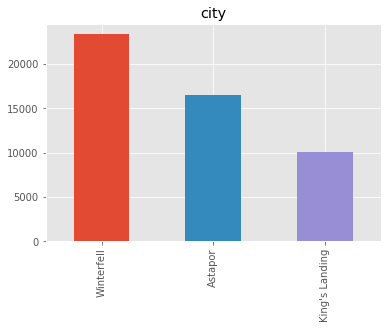

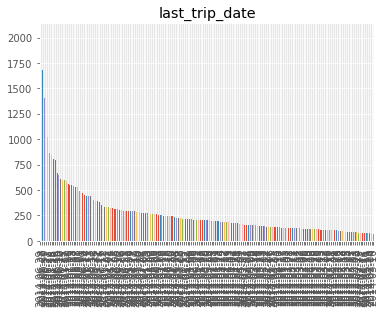

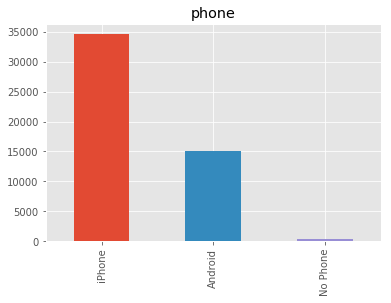

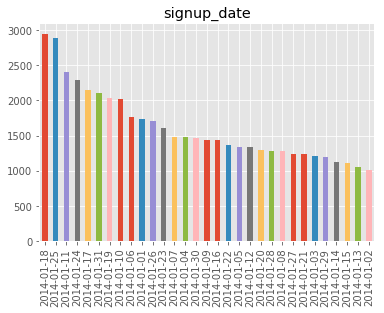

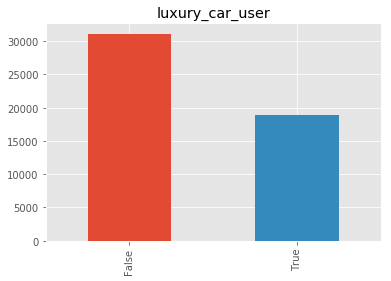

[None, None, None, None, None]

In [10]:
[df[feature].value_counts().plot.bar() and plt.title(feature) and plt.show() for feature in cat_features]

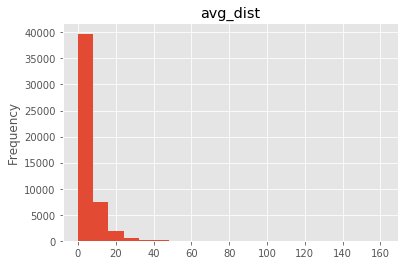

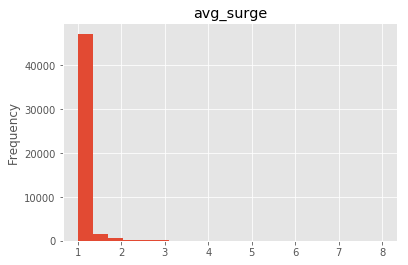

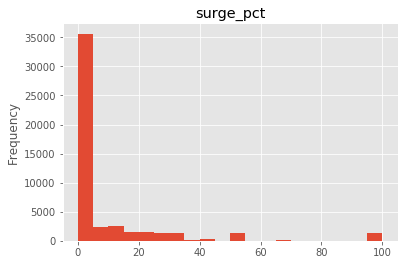

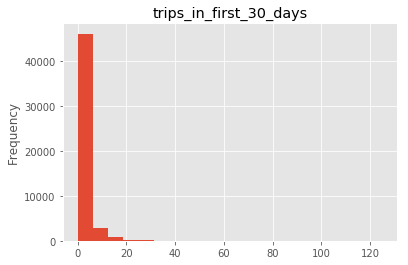

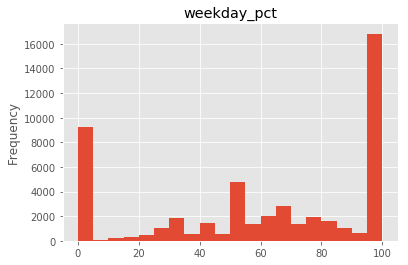

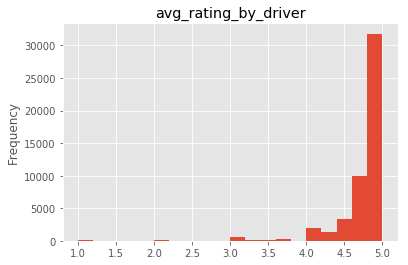

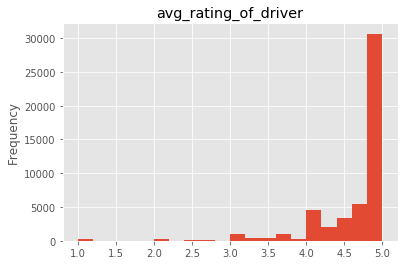

[None, None, None, None, None, None, None]

In [11]:
[df[feature].plot.hist(bins=20) and plt.title(feature) and plt.show() for feature in num_features]

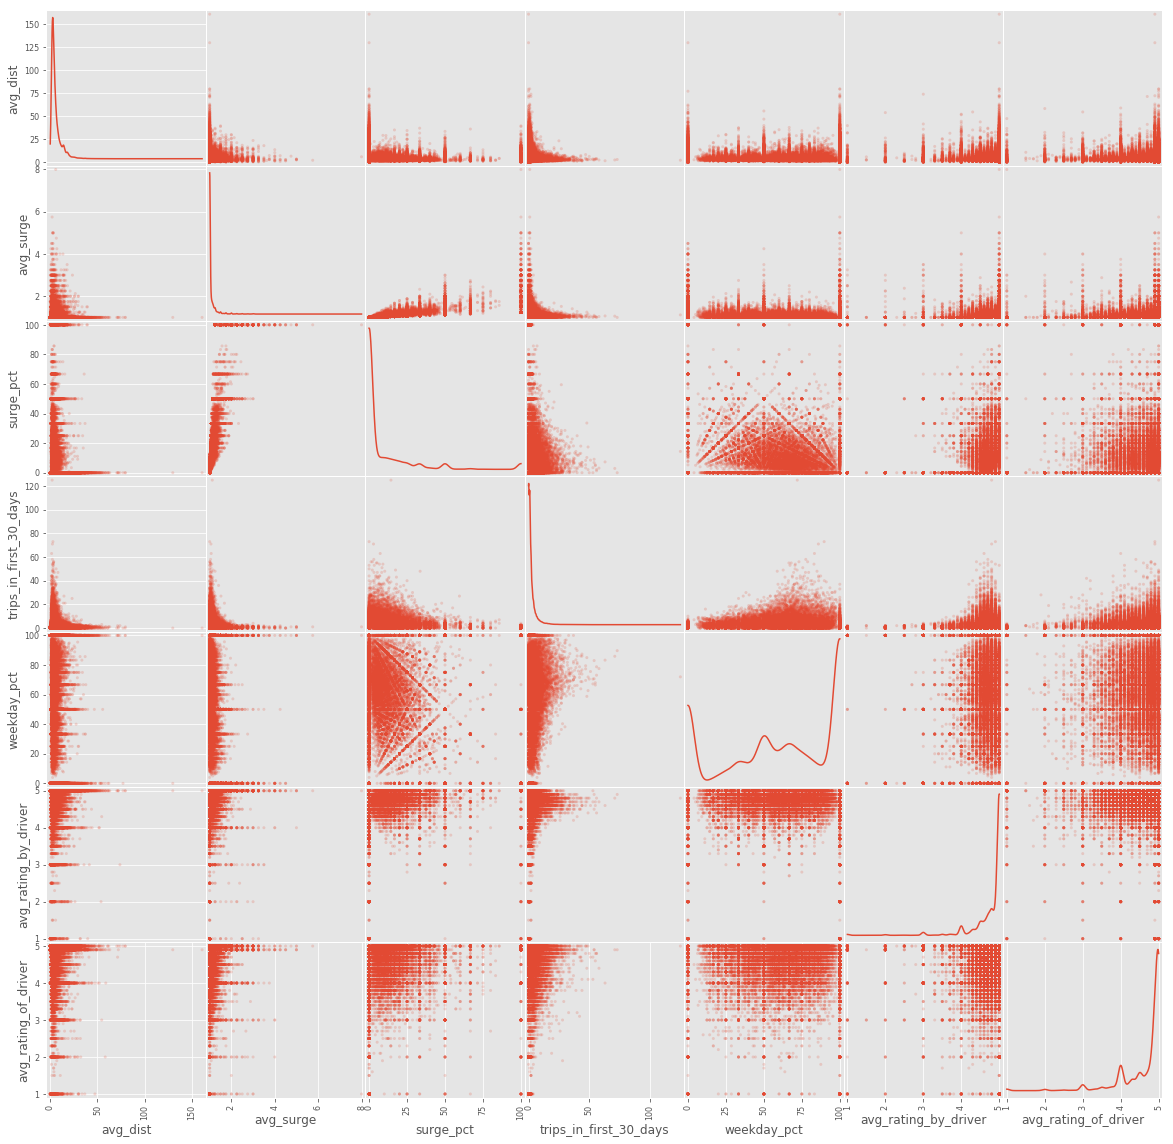

In [12]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[num_features], alpha=0.2, figsize=(20,20), diagonal='kde')
plt.show()

Transfer string to date_time

In [13]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

Plot signup date of month

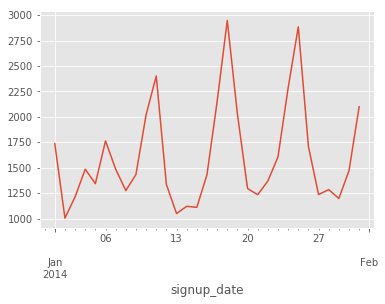

In [14]:
df_timestamp = df[['last_trip_date', 'signup_date']].copy()
df_timestamp['count'] = 1
df_timestamp.set_index('signup_date', inplace=True)
df_timestamp['count'].resample('1D').sum().plot()

Create a new feature signup day of week

In [15]:
df['signup_dow'] = df['signup_date'].apply(lambda x: x.dayofweek)
df.drop('signup_date', axis=1, inplace=True)

Check df

In [16]:
df.head()

,avg_dist,avg_surge,city,last_trip_date,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,avg_rating_by_driver,avg_rating_of_driver,signup_dow
0,3.67,1.10,King's Landing,2014-06-17,iPhone,15.4,4,True,46.2,5.0,4.7,5
1,8.26,1.00,Astapor,2014-05-05,Android,0.0,0,False,50.0,5.0,5.0,2
2,0.77,1.00,Astapor,2014-01-07,iPhone,0.0,3,False,100.0,5.0,4.3,0
3,2.36,1.14,King's Landing,2014-06-29,iPhone,20.0,9,True,80.0,4.9,4.6,4
4,3.13,1.19,Winterfell,2014-03-15,Android,11.8,14,False,82.4,4.9,4.4,0


Add label

In [17]:
df['churn'] = (df.last_trip_date <= pd.to_datetime('2014-06-01'))
df.drop('last_trip_date', axis=1, inplace=True)

Identify non-numerical features in the dataframe

In [18]:
nominal_var = ['city', 'phone']
binary_var = ['luxury_car_user', 'churn']

Encode nominal features to one hot encoders

In [19]:
df_dum = pd.get_dummies(df[nominal_var], drop_first=True)
df = df.join(df_dum)
df.drop(nominal_var, axis=1, inplace=True)

Encode binary features to boolean values

In [20]:
for var in binary_var:
    class_mapping = {label:idx for idx,label in enumerate(np.unique(df[var]))}
    df[var] = df[var].map(class_mapping)

Implement a function to plot churn rate against categorical feature

In [21]:
def hist_active_vs_churn(df, col_name):
    is_active = df['churn'] == 0
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].hist(df[is_active][col_name].values)
    axes[1].hist(df[~is_active][col_name].values)
    fig.tight_layout()
    plt.show()

Plot churn rate

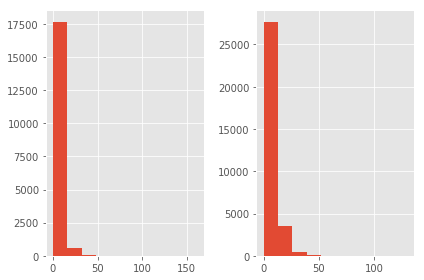

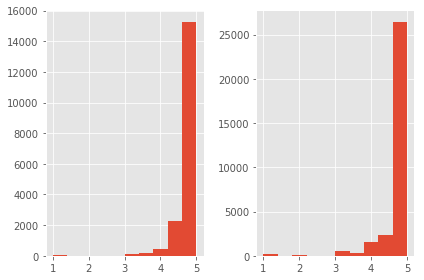

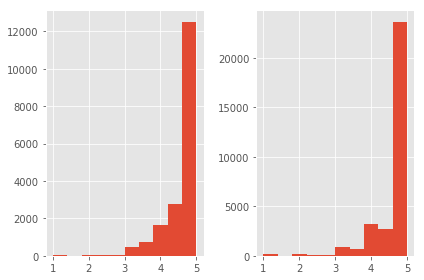

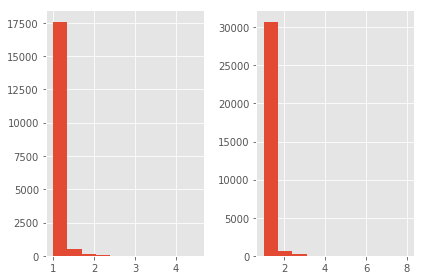

In [22]:
cols = [u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge']
for col in cols:
    hist_active_vs_churn(df, col_name=col)

Identify features and target

In [23]:
selected_features = [u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', 
                     u'surge_pct', u'trips_in_first_30_days', u'luxury_car_user', 
                     u'weekday_pct', u'city_King\'s Landing',u'city_Winterfell', 
                     u'phone_iPhone', u'phone_No Phone']
target = u'churn'

X = df[selected_features].values
y = df[target].values

Split train test sets

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

Helper method to print metric scores    

In [25]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

Implement function to plot ROC curve

In [26]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Implement function to train model and plot ROC curve

In [27]:
def train_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    y_train_p = clf.predict(X_train)
    p_train_p = clf.predict_proba(X_train)[:,1]

    y_test_p = clf.predict(X_test)
    p_test_p = clf.predict_proba(X_test)[:,1]

    print('Training Accuracy:', clf.score(X_train, y_train))
    print('Testing Accuracy:,', clf.score(X_test, y_test))
    plot_roc_curve(y_train, p_train_p, y_test, p_test_p)

LogisticRegression Classfier with l1 regularization

Training Accuracy: 0.7254
Testing Accuracy:, 0.7259


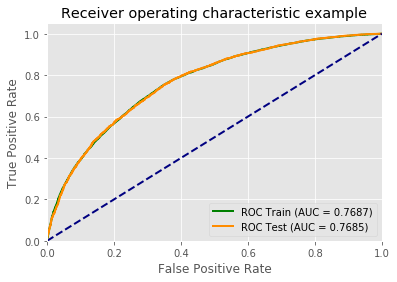

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1')

train_model(clf, X_train, y_train, X_test, y_test)

Single decision tree classifier

Training Accuracy: 0.794925
Testing Accuracy:, 0.7794


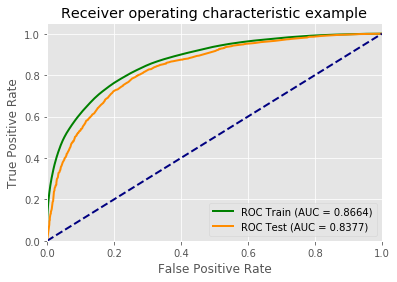

In [29]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)

train_model(clf, X_train, y_train, X_test, y_test)

Decision tree classifier with bagging

Training Accuracy: 0.802525
Testing Accuracy:, 0.7851


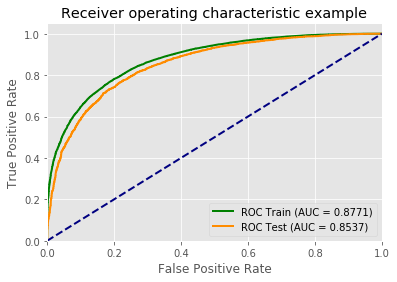

In [30]:
from sklearn.ensemble import BaggingClassifier

base_clf = DecisionTreeClassifier(max_depth=11, min_samples_leaf=30)

clf = BaggingClassifier(base_estimator=base_clf, n_jobs=-1, n_estimators=50)

train_model(clf, X_train, y_train, X_test, y_test)

KNN classifier with k = 20

Training Accuracy: 0.781075
Testing Accuracy:, 0.764


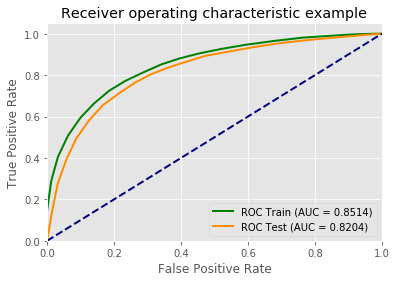

In [31]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)

train_model(clf, X_train, y_train, X_test, y_test)

KNN classifier with bagging n = 100

Training Accuracy: 0.78135
Testing Accuracy:, 0.7649


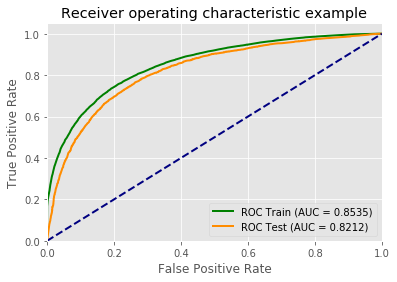

In [32]:
base_clf = KNeighborsClassifier(n_neighbors=20, n_jobs=-1)

clf = BaggingClassifier(base_estimator=base_clf, n_jobs=-1, n_estimators=50)

train_model(clf, X_train, y_train, X_test, y_test)

Random Forest Classifier

Training Accuracy: 0.82495
Testing Accuracy:, 0.7908


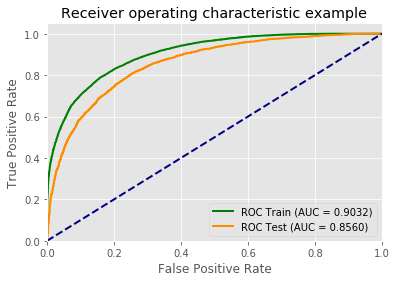

In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, random_state=1, n_jobs=-1)

train_model(clf, X_train, y_train, X_test, y_test)

Gradient Boosting Classifier

Training Accuracy: 0.805575
Testing Accuracy:, 0.7963


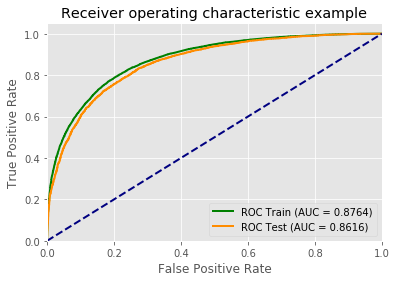

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 50,
    'max_depth': 5,
    'learning_rate': 0.2,
    'random_state': 1
}

clf = GradientBoostingClassifier(**parameters)
train_model(clf, X_train, y_train, X_test, y_test)